## Collecting Data

In this quick demo, we'll use the `datacollection` module in Mesa to extract information on the agent or model level. We'll use this to develop the Schelling Model code that we wrote last time. Ultimately, we'll take these capabilities and use them to create a fun little app for visualizing the Schelling model. 

Here's our base code: 

In [9]:
from mesa.space import SingleGrid
from mesa import Model, Agent
from mesa.time import RandomActivation
import numpy as np
import pandas as pd

class SchellingAgent(Agent):
    
    # adding a pos instance variable so that each agent can remember
    # where they are. Note that the pos can take the place of the name. 
    def __init__(self, pos, agent_type, homophily, model):
        super().__init__(pos, model)
        self.pos = pos
        self.type = agent_type
        self.homophily = homophily
    
    def step(self):
        
        pct_similar_neighbors = np.mean([
            self.type == other.type for other in self.model.grid.neighbor_iter(self.pos)
        ])
        
        if pct_similar_neighbors < self.homophily:
            self.model.grid.move_to_empty(self)
            self.model.moved += 1   
        
class SchellingModel(Model):
    
    # need to specify width, height, and density of agents
    # in the grid. 
    def __init__(self, width, height, density, homophily):
        
        self.schedule = RandomActivation(self)
        
        # create the grid
        self.grid = SingleGrid(width, height, torus=True)
        
        # loop through the grid, and add agents so that the 
        # overall density is roughly equal to the passed 
        # density
        for cell in self.grid.coord_iter():
            x = cell[1]
            y = cell[2]
            if self.random.random() < density:
                
                agent_type = np.random.choice(["triangle", "square"])
                
                agent = SchellingAgent(pos = (x, y), 
                                 agent_type = agent_type, 
                                 homophily = homophily, 
                                 model = self)
                
                self.schedule.add(agent)    
                self.grid.position_agent(agent, (x, y))
            
    # this doesn't change, except that we will add a counter for the number of happy agents
    # who don't move in this timestep
    def step(self):
        self.moved = 0
        self.schedule.step()
        print(f"{self.moved} agents moved in this timestep")

In [10]:
SM = SchellingModel(20, 20, 0.9, 0.5)
SM.step()

131 agents moved in this timestep


## Adding Data Collection

To add data collection to our model, we need to do two things. 

In [17]:
from mesa.datacollection import DataCollector

class SchellingAgent(Agent):
    
    # adding a pos instance variable so that each agent can remember
    # where they are. Note that the pos can take the place of the name. 
    def __init__(self, pos, agent_type, homophily, model):
        super().__init__(pos, model)
        self.pos = pos
        self.type = agent_type
        self.homophily = homophily
    
    def step(self):
        
        pct_similar_neighbors = np.mean([
            self.type == other.type for other in self.model.grid.neighbor_iter(self.pos)
        ])
        
        if pct_similar_neighbors < self.homophily:
            self.model.grid.move_to_empty(self)
            self.model.moved += 1   
        
class SchellingModel(Model):
    
    # need to specify width, height, and density of agents
    # in the grid. 
    def __init__(self, width, height, density, homophily):
        
        self.schedule = RandomActivation(self)
        
        # create the grid
        self.grid = SingleGrid(width, height, torus=True)
        
        # loop through the grid, and add agents so that the 
        # overall density is roughly equal to the passed 
        # density
        for cell in self.grid.coord_iter():
            x = cell[1]
            y = cell[2]
            if self.random.random() < density:
                
                agent_type = np.random.choice(["triangle", "square"])
                
                agent = SchellingAgent(pos = (x, y), 
                                 agent_type = agent_type, 
                                 homophily = homophily, 
                                 model = self)
                
                self.schedule.add(agent)    
                self.grid.position_agent(agent, (x, y))
        
        # NEW: create data collector
        self.collector = DataCollector(model_reporters={"num_moved": lambda m: m.moved},
                                       agent_reporters = {"x"      : lambda a: a.pos[0],
                                                          "y"      : lambda a: a.pos[1],
                                                          "type"   : lambda a: a.type})
        
    # this doesn't change, except that we will add a counter for the number of happy agents
    # who don't move in this timestep
    def step(self):
        self.moved = 0
        self.schedule.step()
        print(f"{self.moved} agents moved in this timestep")
        
        # NEW: call the data collector after each step
        self.collector.collect(self)

In [18]:
SM = SchellingModel(20, 20, 0.9, 0.5)
for i in range(10):
    SM.step()

147 agents moved in this timestep
71 agents moved in this timestep
37 agents moved in this timestep
23 agents moved in this timestep
14 agents moved in this timestep
11 agents moved in this timestep
7 agents moved in this timestep
4 agents moved in this timestep
2 agents moved in this timestep
1 agents moved in this timestep


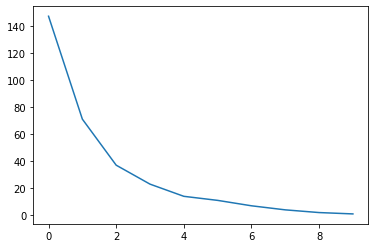

In [22]:
from matplotlib import pyplot as plt
model_vars = SM.collector.get_model_vars_dataframe()
plt.plot(model_vars["num_moved"])

In [20]:
SM.collector.get_agent_vars_dataframe()

x   y      type
Step AgentID                   
1    (0, 0)    10  11    square
     (0, 1)    12  13    square
     (0, 2)     6   8    square
     (0, 3)     5   6    square
     (0, 4)    18   1    square
...            ..  ..       ...
10   (19, 12)  12   4  triangle
     (19, 16)  12   6  triangle
     (19, 17)  17  18    square
     (19, 18)   8   7  triangle
     (19, 19)   8  10  triangle

[3570 rows x 3 columns]